<a href="https://colab.research.google.com/github/dhruvilmaniar/Neuralnet-Visualizer/blob/master/src/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Neural Network Visualizer 


Authentication to use Google drive from colab:

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [2]:
%mkdir 'NN_Vis'/
%cd 'NN_Vis'/

/content/NN_Vis


In [0]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [5]:
print(tf.__version__)

2.2.0


###Loading the dataset:

tensorflow API makes it simple to test features on mnist and fashion mnist dataset.

Here for I've used fashion mnist dataset.

In [6]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

Ploting some of the images from train set to get the idea of dataset:

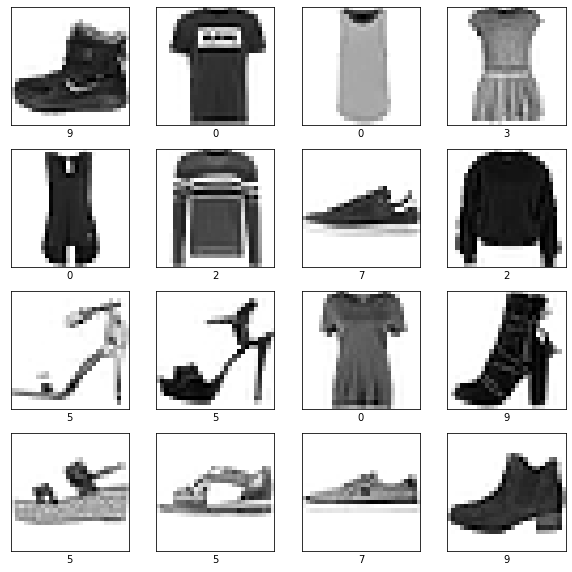

In [7]:
plt.figure(figsize=(10, 10))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(x_train[i], cmap='binary')
    plt.xlabel(str(y_train[i]))
    plt.xticks([])
    plt.yticks([])
plt.show()

###Normalizing the data:

The data contains values from 0 to 255, which is normalized for faster execution.

In [0]:
x_train = np.reshape(x_train, (60000, 784))
x_train = x_train / 255.

x_test = np.reshape(x_test, (10000, 784))
x_test = x_test / 255.

In [9]:
x_train[1].shape, y_train[1].shape

((784,), ())

##Defining the model architecture :

A simple model with total 2 hidden and 1 output layer is defined, so that the visulization can be attractive.

In [0]:
def create_model():

    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(32, activation='relu', input_shape=(784,)),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

    model.compile(loss='sparse_categorical_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy']
          )
    
    return model

In [0]:
model = create_model()

In [24]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 32)                25120     
_________________________________________________________________
dense_13 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_14 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_15 (Dense)             (None, 10)                330       
Total params: 27,562
Trainable params: 27,562
Non-trainable params: 0
_________________________________________________________________


In [25]:
_ = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=20, batch_size=1024,
    verbose=2
) 
// No callbacks are used in this simple model.

Epoch 1/20
59/59 - 1s - loss: 1.3752 - accuracy: 0.5291 - val_loss: 0.7302 - val_accuracy: 0.7497
Epoch 2/20
59/59 - 0s - loss: 0.6009 - accuracy: 0.7944 - val_loss: 0.5584 - val_accuracy: 0.8068
Epoch 3/20
59/59 - 0s - loss: 0.5002 - accuracy: 0.8274 - val_loss: 0.5065 - val_accuracy: 0.8224
Epoch 4/20
59/59 - 0s - loss: 0.4552 - accuracy: 0.8414 - val_loss: 0.4846 - val_accuracy: 0.8302
Epoch 5/20
59/59 - 0s - loss: 0.4331 - accuracy: 0.8489 - val_loss: 0.4737 - val_accuracy: 0.8310
Epoch 6/20
59/59 - 0s - loss: 0.4126 - accuracy: 0.8561 - val_loss: 0.4490 - val_accuracy: 0.8440
Epoch 7/20
59/59 - 0s - loss: 0.3995 - accuracy: 0.8601 - val_loss: 0.4340 - val_accuracy: 0.8490
Epoch 8/20
59/59 - 0s - loss: 0.3889 - accuracy: 0.8640 - val_loss: 0.4303 - val_accuracy: 0.8488
Epoch 9/20
59/59 - 0s - loss: 0.3775 - accuracy: 0.8671 - val_loss: 0.4150 - val_accuracy: 0.8535
Epoch 10/20
59/59 - 0s - loss: 0.3688 - accuracy: 0.8705 - val_loss: 0.4394 - val_accuracy: 0.8466
Epoch 11/20
59/59 -

For this simple project, the model is saved as ```.h5py``` format.

In [0]:
model.save('model.h5')    

As I am using google colab, the following code will upload the model to my drive.

The same can be used to store this notebook as well as server.py and app.py.

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
model_file = drive.CreateFile({'title' : 'model.h5'})
model_file.SetContentFile('model.h5')
model_file.Upload()

In [30]:
print('Uploaded file with ID {}'.format(model_file.get('id')))

Uploaded file with ID 1pXmr_fyZfSg5vk--jKc_86VnY597AjOa


##Creating server for the application using flask:

Here the server is created using flask and inferencing is performed by loading the above saved model.
Also, the result is sent to the frontend, which contains the prediction as well as values for each layer of the network.

In [0]:
%mkdir src
%cd src

In [37]:
%%writefile ml_server.py

import json
import tensorflow as tf
import numpy as np
import os
import random
import string

from flask import Flask, request

app = Flask(__name__)

model = tf.keras.models.load_model('model.h5')
feature_model = tf.keras.models.Model(model.inputs, [layer.output for layer in model.layers])

_, (x_test, _) = tf.keras.datasets.mnist.load_data()
x_test = x_test / 255.

def get_prediction():
    index = np.random.choice(x_test.shape[0])
    image = x_test[index,:,:]
    image_arr = np.reshape(image, (1, 784))
    return feature_model.predict(image_arr), image

@app.route('/', methods=['GET', 'POST'])
def index():
    if request.method == 'POST':
        preds, image = get_prediction()
        final_preds = [p.tolist() for p in preds]
        return json.dumps({'prediction': final_preds, 'image': image.tolist()})
    return 'Welcome to the ml server'

if __name__ == '__main__':
    app.run()


Writing ./src/ml_server.py


##Creating streamlit UI and ploting the response recieved from the server:

In [36]:
%%writefile app.py

import requests
import json
import numpy as np
import streamlit as st
import os
import matplotlib.pyplot as plt

URI = 'http://127.0.0.1:5000'

st.title('Neural Network Visualizer')
st.sidebar.markdown('# Input Image')

if st.button('Get random predictions'):
    response = requests.post(URI, data={})
    response = json.loads(response.text)
    preds = response.get('prediction')
    image = response.get('image')
    image = np.reshape(image, (28, 28))

    st.sidebar.image(image, width=150)

    for layer, p in enumerate(preds):
        numbers = np.squeeze(np.array(p))

        plt.figure(figsize=(32, 4))

        if layer == 2:
            row = 1
            col = 10
        else:
            row = 2
            col = 16

        for i, number in enumerate(numbers):
            plt.subplot(row, col, i + 1)
            plt.imshow((number * np.ones((8, 8, 3))).astype('float32'), cmap='binary')
            plt.xticks([])
            plt.yticks([])
            if layer == 2:
                plt.xlabel(str(i), fontsize=40)
        plt.subplots_adjust(wspace=0.05, hspace=0.05)
        plt.tight_layout()

        st.text('Layer {}'.format(layer + 1), )
        st.pyplot()


Writing ./src/app.py
